# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [72]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os
from wordcloud import WordCloud
from datetime import datetime
import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode()

In [73]:
# using SQLite Table to read data.
con = sqlite3.connect('D:\\downloadfolder\\database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (500000, 10)


Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      1  1303862400   
1                     0                       0      0  1346976000   
2                     1                       1      1  1219017600   

                 Summary                                               Text  
0  Good Quality Dog Food  I have bought several of the Vitality canned d...  
1      Not as Advertised  Product arrived labeled as Jumbo Salted Peanut...  
2  "Delight" says it all  This is a confection that has been around a fe...

In [74]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [75]:
print(display.shape)
display.head()

(80668, 7)


UserId   ProductId             ProfileName        Time  Score  \
0  #oc-R115TNMSPFT9I7  B007Y59HVM                 Breyton  1331510400      2   
1  #oc-R11D9D7SHXIJB9  B005HG9ET0  Louis E. Emory "hoppy"  1342396800      5   
2  #oc-R11DNU2NBKQ23Z  B007Y59HVM        Kim Cieszykowski  1348531200      1   
3  #oc-R11O5J5ZVQE25C  B005HG9ET0           Penguin Chick  1346889600      5   
4  #oc-R12KPBODL2B5ZD  B007OSBE1U   Christopher P. Presta  1348617600      1   

                                                Text  COUNT(*)  
0  Overall its just OK when considering the price...         2  
1  My wife has recurring extreme muscle spasms, u...         3  
2  This coffee is horrible and unfortunately not ...         2  
3  This will be the bottle that you grab from the...         3  
4  I didnt like this coffee. Instead of telling y...         2

In [76]:
display[display['UserId']=='AZY10LLTJ71NX']

UserId   ProductId                      ProfileName        Time  \
80638  AZY10LLTJ71NX  B006P7E5ZI  undertheshrine "undertheshrine"  1334707200   

       Score                                               Text  COUNT(*)  
80638      5  I was recommended to try green tea extract to ...         5

In [77]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [78]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

Id   ProductId         UserId      ProfileName  HelpfulnessNumerator  \
0   78445  B000HDL1RQ  AR5J8UI46CURR  Geetha Krishnan                     2   
1  138317  B000HDOPYC  AR5J8UI46CURR  Geetha Krishnan                     2   
2  138277  B000HDOPYM  AR5J8UI46CURR  Geetha Krishnan                     2   
3   73791  B000HDOPZG  AR5J8UI46CURR  Geetha Krishnan                     2   
4  155049  B000PAQ75C  AR5J8UI46CURR  Geetha Krishnan                     2   

   HelpfulnessDenominator  Score        Time  \
0                       2      5  1199577600   
1                       2      5  1199577600   
2                       2      5  1199577600   
3                       2      5  1199577600   
4                       2      5  1199577600   

                             Summary  \
0  LOACKER QUADRATINI VANILLA WAFERS   
1  LOACKER QUADRATINI VANILLA WAFERS   
2  LOACKER QUADRATINI VANILLA WAFERS   
3  LOACKER QUADRATINI VANILLA WAFERS   
4  LOACKER QUADRATINI VANILLA WAFERS   

                                                Text  
0  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
1  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
2  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
3  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
4  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...

As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [79]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [80]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(348262, 10)

In [81]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.6524

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [82]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

Id   ProductId          UserId              ProfileName  \
0  64422  B000MIDROQ  A161DK06JJMCYF  J. E. Stephens "Jeanne"   
1  44737  B001EQ55RW  A2V0I904FH7ABY                      Ram   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     3                       1      5  1224892800   
1                     3                       2      4  1212883200   

                                        Summary  \
0             Bought This for My Son at College   
1  Pure cocoa taste with crunchy almonds inside   

                                                Text  
0  My son loves spaghetti so I didn't hesitate or...  
1  It was almost a 'love at first bite' - the per...

In [83]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [84]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(348260, 10)


1    293516
0     54744
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [85]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

This book was purchased as a birthday gift for a 4 year old boy. He squealed with delight and hugged it when told it was his to keep and he did not have to return it to the library.
I've purchased both the Espressione Espresso (classic) and the 100% Arabica.  My vote is definitely with the 100% Arabica.  The flavor has more bite and flavor (much more like European coffee than American).
This is a great product. It is very healthy for all of our dogs, and it is the first food that they all love to eat. It helped my older dog lose weight and my 10 year old lab gain the weight he needed to be healthy.
I find everything I need at Amazon so I always look there first. Chocolate tennis balls for a tennis party, perfect! They were the size of malted milk balls. Unfortunately, they arrived 3 days after the party. The caveat here is, not everything from Amazon may arrive at an impressive 2 or 3 days. This shipment took 8 days from the Candy/Cosmetic Depot back east to southern California.


In [86]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

This book was purchased as a birthday gift for a 4 year old boy. He squealed with delight and hugged it when told it was his to keep and he did not have to return it to the library.


In [87]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

This book was purchased as a birthday gift for a 4 year old boy. He squealed with delight and hugged it when told it was his to keep and he did not have to return it to the library.
I've purchased both the Espressione Espresso (classic) and the 100% Arabica.  My vote is definitely with the 100% Arabica.  The flavor has more bite and flavor (much more like European coffee than American).
This is a great product. It is very healthy for all of our dogs, and it is the first food that they all love to eat. It helped my older dog lose weight and my 10 year old lab gain the weight he needed to be healthy.
I find everything I need at Amazon so I always look there first. Chocolate tennis balls for a tennis party, perfect! They were the size of malted milk balls. Unfortunately, they arrived 3 days after the party. The caveat here is, not everything from Amazon may arrive at an impressive 2 or 3 days. This shipment took 8 days from the Candy/Cosmetic Depot back east to southern California.


In [88]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [89]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

This is a great product. It is very healthy for all of our dogs, and it is the first food that they all love to eat. It helped my older dog lose weight and my 10 year old lab gain the weight he needed to be healthy.


In [90]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

This book was purchased as a birthday gift for a  year old boy. He squealed with delight and hugged it when told it was his to keep and he did not have to return it to the library.


In [91]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

This is a great product It is very healthy for all of our dogs and it is the first food that they all love to eat It helped my older dog lose weight and my 10 year old lab gain the weight he needed to be healthy 


In [92]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [93]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in final['Text'].values:
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

In [94]:
preprocessed_reviews[1500]

'great product healthy dogs first food love eat helped older dog lose weight year old lab gain weight needed healthy'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [95]:
## Similartly you can do preprocessing for review summary also.

In [96]:
final["preprocessed_reviews"] = preprocessed_reviews

In [97]:
final.head()

Id   ProductId          UserId                     ProfileName  \
138702  150520  0006641040   ADBFSA9KTQANE  James L. Hammock "Pucks Buddy"   
138707  150525  0006641040  A2QID6VCFTY51R                            Rick   
138708  150526  0006641040  A3E9QZFE9KXH8J                     R. Mitchell   
138692  150510  0006641040   AM1MNZMYMS7D8            Dr. Joshua  Grossman   
138689  150507  0006641040  A1S4A3IQ2MU7V4           sally sue "sally sue"   

        HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
138702                     0                       0      1  1256688000   
138707                     1                       2      1  1025481600   
138708                    11                      18      0  1129507200   
138692                     0                       0      1  1348358400   
138689                     1                       1      1  1191456000   

                                                  Summary  \
138702                                         Great Gift   
138707  In December it will be, my snowman's anniversa...   
138708                             awesome book poor size   
138692                             Professional Mentoring   
138689                      chicken soup with rice months   

                                                     Text  \
138702  This book was purchased as a birthday gift for...   
138707  My daughter loves all the "Really Rosie" books...   
138708  This is one of the best children's books ever ...   
138692  TITLE: Chicken Soup with Rice<br />AUTHOR: Mau...   
138689  This is a fun way for children to learn their ...   

                                     preprocessed_reviews  
138702  book purchased birthday gift year old boy sque...  
138707  daughter loves really rosie books introduced r...  
138708  one best children books ever written mini vers...  
138692  title chicken soup riceauthor maurice sendakre...  
138689  fun way children learn months year learn poems...

In [98]:
final=final.drop(["Id","ProductId","UserId","ProfileName","HelpfulnessNumerator"],axis=1)

In [99]:
final_last=final.drop(["HelpfulnessDenominator","Time","Summary","Text"],axis=1)

In [100]:
final_last.shape

(348260, 2)

In [101]:
final_last.head()

Score                               preprocessed_reviews
138702      1  book purchased birthday gift year old boy sque...
138707      1  daughter loves really rosie books introduced r...
138708      0  one best children books ever written mini vers...
138692      1  title chicken soup riceauthor maurice sendakre...
138689      1  fun way children learn months year learn poems...

In [102]:
X = final_last["preprocessed_reviews"]

Y = final_last["Score"]

In [103]:
from sklearn.model_selection import train_test_split

x_train ,x_test ,y_train ,y_test = train_test_split(X[:100000], Y[:100000] , test_size = 0.33)

# [4] Featurization

## [4.1] BAG OF WORDS

## [4.2] Bi-Grams and n-Grams.

In [104]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect_bow = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
x_train_bigram_counts = count_vect_bow.fit_transform(x_train)
x_test_bigram_counts = count_vect_bow.transform(x_test)

print("After Vectorizations")
print("the type of count vectorizer ",type(x_train_bigram_counts))
print("the shape of out train text BOW vectorizer ",x_train_bigram_counts.get_shape())
print("the shape of test text BOW vectorizer ",x_test_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", x_train_bigram_counts.get_shape()[1])

After Vectorizations
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out train text BOW vectorizer  (67000, 5000)
the shape of test text BOW vectorizer  (33000, 5000)
the number of unique words including both unigrams and bigrams  5000


## [4.3] TF-IDF

In [105]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10 ,max_features = 5000)
tf_idf_vect.fit(x_train)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

x_train_tf_idf = tf_idf_vect.transform(x_train)
x_test_tf_idf = tf_idf_vect.transform(x_test)
print("the type of count vectorizer ",type(x_train_tf_idf))
print("the shape of train text TFIDF vectorizer ",x_train_tf_idf.get_shape())
print("the shape of test text TFIDF vectorizer ",x_test_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", x_train_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['ability', 'able', 'able buy', 'able find', 'able get', 'able order', 'absolute', 'absolute favorite', 'absolutely', 'absolutely best']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of train text TFIDF vectorizer  (67000, 5000)
the shape of test text TFIDF vectorizer  (33000, 5000)
the number of unique words including both unigrams and bigrams  5000


## [4.4] Word2Vec

In [106]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance_train=[]
for sentance in x_train:
    list_of_sentance_train.append(sentance.split())

In [107]:
# min_count = 5 considers only words that occured atleast 5 times
w2v_model_train=Word2Vec(list_of_sentance_train,min_count=5,size=50, workers=4)
print(w2v_model_train.wv.most_similar('great'))
print('='*50)
print(w2v_model_train.wv.most_similar('worst'))
    


[('terrific', 0.8438560366630554), ('good', 0.8209481239318848), ('awesome', 0.818634569644928), ('excellent', 0.8179408311843872), ('fantastic', 0.8118878602981567), ('wonderful', 0.8002343773841858), ('perfect', 0.7247747182846069), ('nice', 0.6765005588531494), ('fabulous', 0.6631278991699219), ('incredible', 0.6597334742546082)]
[('greatest', 0.7450196146965027), ('best', 0.7418639659881592), ('disgusting', 0.6873143911361694), ('awful', 0.6522606015205383), ('nicest', 0.6512683629989624), ('terrible', 0.6407781839370728), ('horrible', 0.6357016563415527), ('tastiest', 0.6330034732818604), ('closest', 0.6237843036651611), ('nastiest', 0.6105952262878418)]


In [108]:
w2v_words_train = list(w2v_model_train.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words_train))
print("sample words ", w2v_words_train[0:50])

number of words that occured minimum 5 times  15769
sample words  ['never', 'good', 'muesli', 'dont', 'think', 'need', 'try', 'brand', 'stuff', 'incredible', 'let', 'sit', 'hour', 'half', 'milk', 'eating', 'throw', 'bananas', 'go', 'town', 'highly', 'recommend', 'love', 'tea', 'coffee', 'alternative', 'tastes', 'great', 'hot', 'cold', 'packed', 'antioxidants', 'make', 'thermos', 'full', 'winter', 'drink', 'morning', 'summer', 'bags', 'minutes', 'poor', 'ice', 'store', 'fridge', 'sometimes', 'use', 'baking', 'often', 'enjoy']


In [109]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sentance_train: # for each review/sentence
    sent_vec_train = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words_train =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_train:
            vec_train = w2v_model_train.wv[word]
            sent_vec_train += vec_train
            cnt_words_train += 1
    if cnt_words_train != 0:
        sent_vec_train /= cnt_words_train
    sent_vectors_train.append(sent_vec_train)
sent_vectors_train = np.array(sent_vectors_train)
print(sent_vectors_train.shape)
print(sent_vectors_train[0])

(67000, 50)
[-0.65892812 -0.47243341 -0.09481759  0.83330739 -0.21341322 -0.79385472
 -0.48954929  0.64341173 -0.1623526  -0.32074858  0.84518089 -0.20750356
 -0.57836309 -0.22616947 -0.17697618  0.25107059  0.19554709 -0.66779009
  0.11388537 -0.23096781  0.04293739  0.2652106  -0.08517535  0.76701833
  0.32085309  1.25749768  0.00361504  0.07733161 -0.99779849 -0.19731173
 -0.25096067 -0.13895273  0.20397911  0.32566336  0.59335048  0.46804576
  0.45078487 -0.25289143  0.62909544 -1.02059205  0.01632896  0.2885348
  0.16409374  0.02665798  0.81980856 -0.21723967  0.44629889  0.00762933
 -0.34753866 -0.37928467]


In [110]:
i=0
list_of_sentance_test = []
for sentence in x_test :
    list_of_sentance_test.append(sentence.split())

In [111]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sentance_test: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_train:
            vec = w2v_model_train.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
sent_vectors_test = np.array(sent_vectors_test)
print(sent_vectors_test.shape)
print(sent_vectors_test[0])

(33000, 50)
[ 0.25051607  0.01102387  0.4310846   0.8980276  -0.0565785  -0.39877253
 -0.97775314  0.27012229 -0.06823902  0.0470408   0.28495867 -0.08671999
 -0.61884458  0.43052835 -0.3973809   0.63702698  0.74909115 -0.27053551
  0.19234379  0.01124956  0.38353608  0.49869414  0.21641725  0.99159943
  0.46139263  0.54367103  0.11466599 -0.49404745 -0.65029876  0.4103073
 -0.6028081  -0.24067192  0.02634844 -0.05577175  0.89483147 -0.15128696
 -0.19952715  0.30846809  0.02674621 -0.63852063 -0.63967792  0.00617524
  0.33155742  0.00584022  0.71971601 -0.79934742 -0.31985364  0.13691569
  0.226608    0.60710041]


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

#### [4.4.1.2] TFIDF weighted W2v

In [112]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix_train = model.fit_transform(x_train)
tf_idf_matrix_test = model.transform(x_test)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [113]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

w2v_tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sentance_train: # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_train and word in tfidf_feat:
            vec = w2v_model_train.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    w2v_tfidf_sent_vectors_train.append(sent_vec)
    row += 1

In [114]:
#test data

w2v_tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sentance_test: # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_train and word in tfidf_feat:
            vec = w2v_model_train.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    w2v_tfidf_sent_vectors_test.append(sent_vec)
    row += 1

In [0]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

# Applying Random Forest

##  Applying Random Forests on BOW,<font color='red'> SET 1</font>

In [46]:
# Please write all the code with proper documentation

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

rf_model_bow=RandomForestClassifier(class_weight='balanced')
parameters={'n_estimators':[5, 10, 50, 100, 500, 100],
           'max_depth':[5 ,10 ,20 ,50 ,75 ,100,]}
clf_bow=GridSearchCV(rf_model_bow,parameters,cv=10,scoring='roc_auc',n_jobs=-1)
clf_bow.fit(x_train_bigram_counts, y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators='warn', n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [5, 10, 50, 100, 500, 100], 'max_depth': [5, 10, 20, 50, 75, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [47]:
print("best estimator is :",clf_bow.best_estimator_)

best estimator is : RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=100, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False)


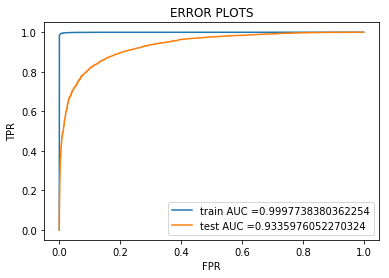

Train confusion matrix
[[ 9832    82]
 [  300 56786]]
Test confusion matrix
[[ 2340  2522]
 [  629 27509]]


In [48]:
#Testing with test data

rf_bow = RandomForestClassifier(class_weight='balanced' ,n_estimators=500 , max_depth=100)
rf_bow.fit(x_train_bigram_counts, y_train)


train_fpr_bow, train_tpr_bow, thresholds_bow = roc_curve(y_train, rf_bow.predict_proba(x_train_bigram_counts)[:,1])
test_fpr_bow, test_tpr_bow, thresholds_bow = roc_curve(y_test, rf_bow.predict_proba(x_test_bigram_counts)[:,1])

plt.plot(train_fpr_bow, train_tpr_bow, label="train AUC ="+str(auc(train_fpr_bow, train_tpr_bow)))
plt.plot(test_fpr_bow, test_tpr_bow, label="test AUC ="+str(auc(test_fpr_bow, test_tpr_bow)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, rf_bow.predict(x_train_bigram_counts)))
print("Test confusion matrix")
print(confusion_matrix(y_test, rf_bow.predict(x_test_bigram_counts)))

In [128]:
n_estimators=[5, 10, 50, 100, 500]
max_depth = [5 ,10 ,20 ,50 ,75]
train_auc = []
test_auc = []
def calculate_auc_score(n_estimators , max_depth, train_data ,test_data):
    for i , j  in zip(n_estimators, max_depth):
        rf_model = RandomForestClassifier(n_estimators = i,max_depth = j , class_weight="balanced")
        rf_model.fit(train_data, y_train)
        train_fpr, train_tpr, thresholds = roc_curve(y_train, rf_model.predict_proba(train_data)[:,1])
        test_fpr, test_tpr, thresholds = roc_curve(y_test, rf_model.predict_proba(test_data)[:,1])
        train_auc.append(auc(train_fpr, train_tpr))
        test_auc.append(auc(test_fpr, test_tpr))
    
    
calculate_auc_score(n_estimators, max_depth , x_train_bigram_counts ,x_test_bigram_counts)

In [134]:
trace1 = go.Scatter3d(x=n_estimators,y=max_depth,z=train_auc, name = 'train')
trace2 = go.Scatter3d(x=n_estimators,y=max_depth,z=test_auc, name = 'test')
data = [trace1, trace2]

layout = go.Layout(scene = dict(
        xaxis = dict(title='n_estimators'),
        yaxis = dict(title='max_depth'),
        zaxis = dict(title='AUC'),))

fig = go.Figure(data=data, layout=layout)
offline.iplot(fig, filename='3d-scatter-colorscale')

### [5.1.1] Top 20 important features from<font color='red'> SET 1</font>

In [108]:
# Please write all the code with proper documentation
coefficients = pd.DataFrame({"Feature":count_vect_bow.get_feature_names(),"Coefficients":np.transpose(rf_bow.feature_importances_)})

coefficients=coefficients.sort_values('Coefficients',ascending=False)

In [114]:
coefficients = coefficients.reset_index()
coefficients = coefficients.drop(["level_0"],axis = 1)
coefficients.head(20)

Coefficients       Feature
0       0.029448           not
1       0.027769         great
2       0.015895          best
3       0.012102          love
4       0.011331     delicious
5       0.011030  disappointed
6       0.007504       perfect
7       0.007363         loves
8       0.006464       not buy
9       0.005883          good
10      0.005845           bad
11      0.005793     wonderful
12      0.005734      favorite
13      0.005696         would
14      0.005495         money
15      0.005308         worst
16      0.005144     excellent
17      0.005044      terrible
18      0.004762       product
19      0.004629          easy

In [115]:
columnTitles = ["Feature" ,"Coefficients"]

coefficients = coefficients.reindex(columns = columnTitles)

coefficients.head(20)

Feature  Coefficients
0            not      0.029448
1          great      0.027769
2           best      0.015895
3           love      0.012102
4      delicious      0.011331
5   disappointed      0.011030
6        perfect      0.007504
7          loves      0.007363
8        not buy      0.006464
9           good      0.005883
10           bad      0.005845
11     wonderful      0.005793
12      favorite      0.005734
13         would      0.005696
14         money      0.005495
15         worst      0.005308
16     excellent      0.005144
17      terrible      0.005044
18       product      0.004762
19          easy      0.004629

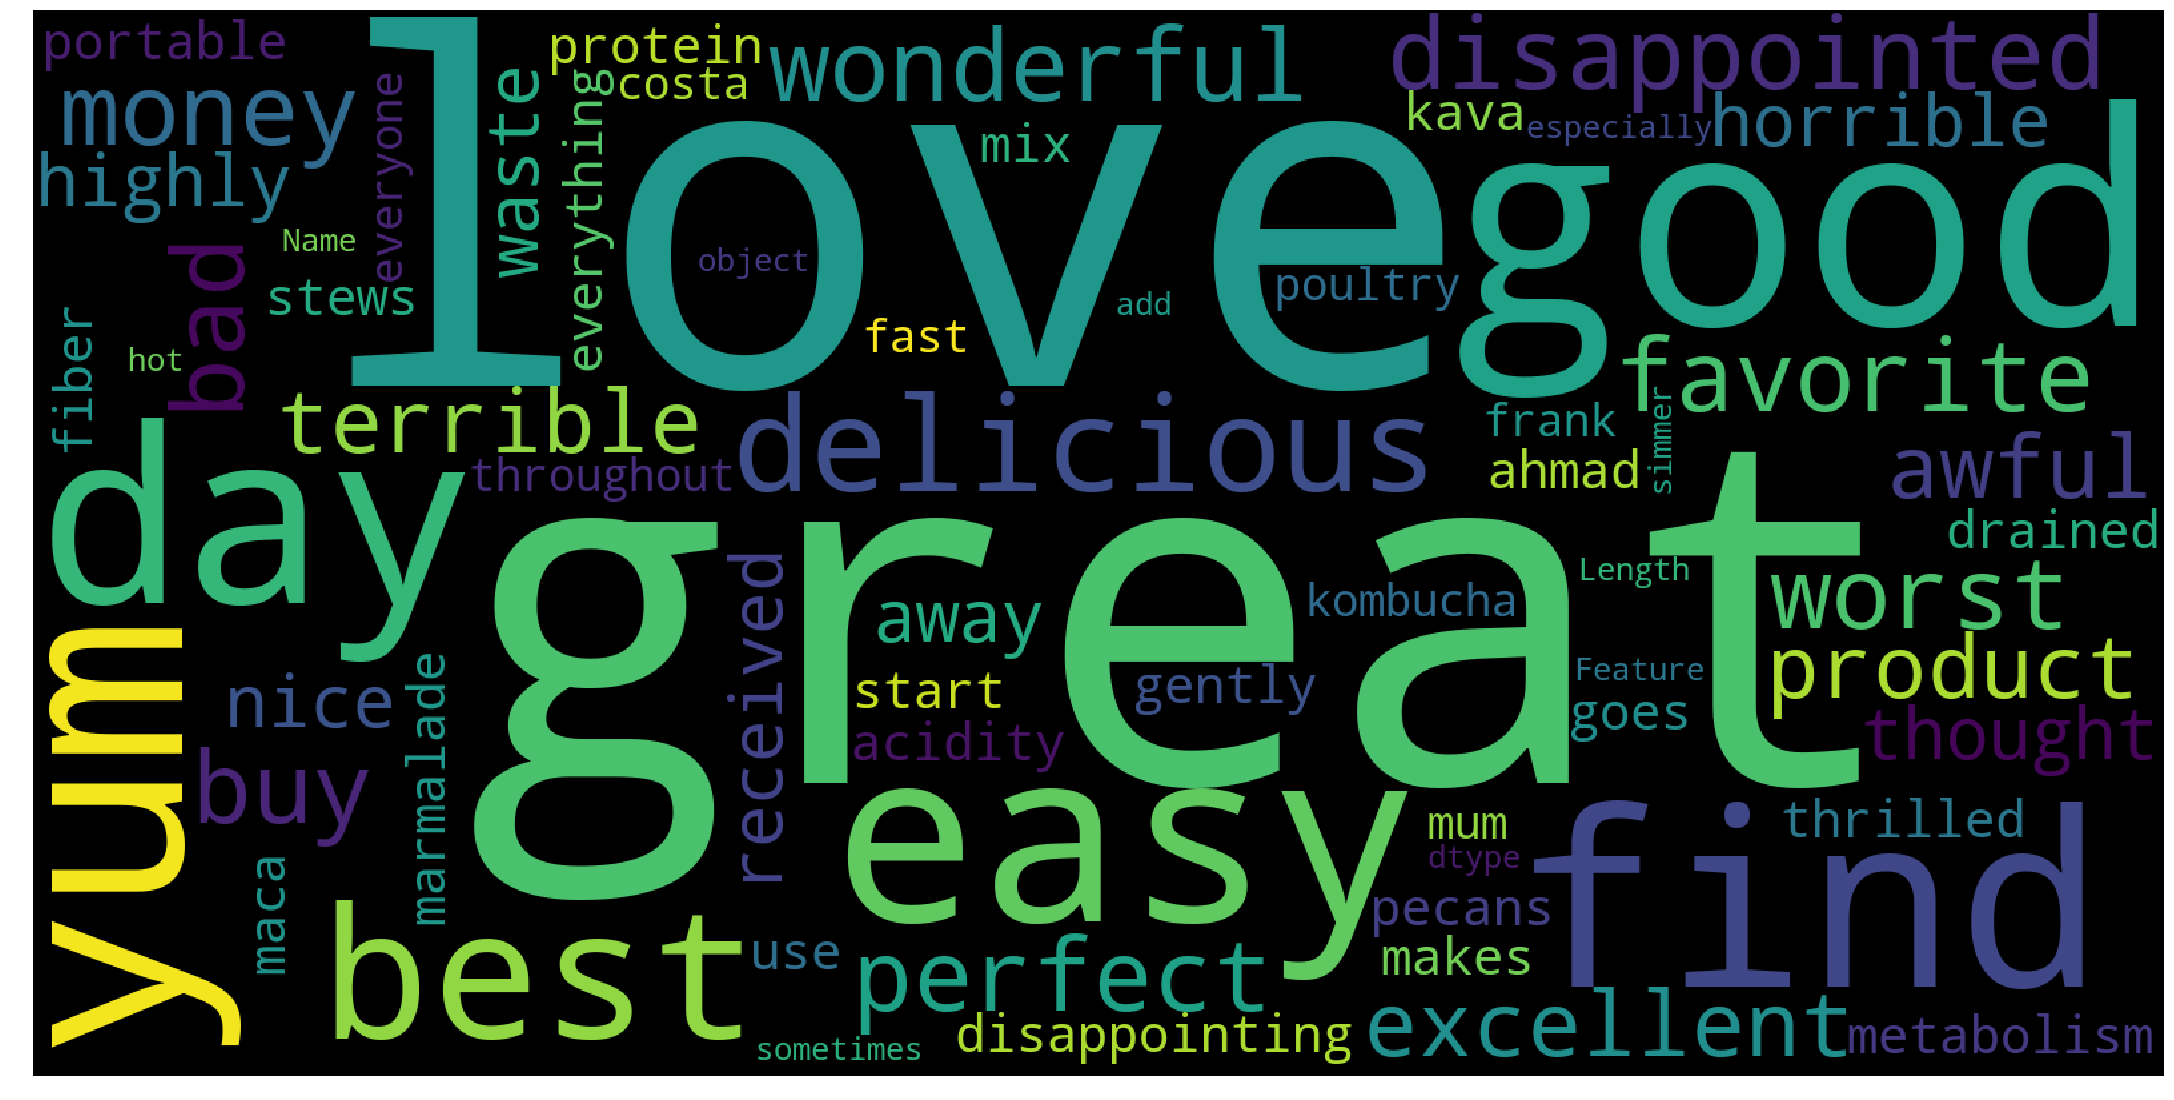

Time taken to run this cell : 0:00:04.252407


In [116]:
# Ploting word cloud
start = datetime.now()

# Lets first convert the 'result' dictionary to 'list of tuples'
#tup = dict(coefficients.items())
#Initializing WordCloud using frequencies of tags.
wordcloud = WordCloud(    background_color='black',
                          width=1600,
                          height=800,
                    ).generate(str(coefficients["Feature"]))

fig = plt.figure(figsize=(30,20))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
fig.savefig("tag.png")
plt.show()
print("Time taken to run this cell :", datetime.now() - start)

## Applying Random Forests on TFIDF,<font color='red'> SET 2</font>

In [52]:
# Please write all the code with proper documentation

# Please write all the code with proper documentation

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

rf_model_bow=RandomForestClassifier(class_weight='balanced')
parameters={'n_estimators':[5, 10, 50, 100, 500],
           'max_depth':[5 ,10 ,20 ,50 ,75]}
clf_tfidf=GridSearchCV(rf_model_bow,parameters,cv=10,scoring='roc_auc',n_jobs=-1)
clf_tfidf.fit(x_train_tf_idf, y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators='warn', n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [5, 10, 50, 100, 500], 'max_depth': [5, 10, 20, 50, 75]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [53]:
print("best estimator is :",clf_tfidf.best_estimator_)

best estimator is : RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=75, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False)


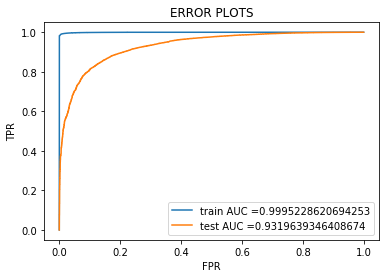

Train confusion matrix
[[ 9802   112]
 [  428 56658]]
Test confusion matrix
[[ 2571  2291]
 [  754 27384]]


In [54]:
#Testing with test data

rf_tfidf = RandomForestClassifier(class_weight='balanced' ,n_estimators=500 , max_depth=75)
rf_tfidf.fit(x_train_tf_idf, y_train)


train_fpr_tfidf, train_tpr_tfidf, thresholds_tfidf = roc_curve(y_train, rf_tfidf.predict_proba(x_train_tf_idf)[:,1])
test_fpr_tfidf, test_tpr_tfidf, thresholds_tfidf = roc_curve(y_test, rf_tfidf.predict_proba(x_test_tf_idf)[:,1])

plt.plot(train_fpr_tfidf, train_tpr_tfidf, label="train AUC ="+str(auc(train_fpr_tfidf, train_tpr_tfidf)))
plt.plot(test_fpr_tfidf, test_tpr_tfidf, label="test AUC ="+str(auc(test_fpr_tfidf, test_tpr_tfidf)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, rf_tfidf.predict(x_train_tf_idf)))
print("Test confusion matrix")
print(confusion_matrix(y_test, rf_tfidf.predict(x_test_tf_idf)))

In [139]:
#emptying train_auc and test_auc
train_auc[:] = []
test_auc[:] = []

calculate_auc_score(n_estimators, max_depth , x_train_tf_idf ,x_test_tf_idf)

In [140]:
trace1 = go.Scatter3d(x=n_estimators,y=max_depth,z=train_auc, name = 'train')
trace2 = go.Scatter3d(x=n_estimators,y=max_depth,z=test_auc, name = 'test')
data = [trace1, trace2]

layout = go.Layout(scene = dict(
        xaxis = dict(title='n_estimators'),
        yaxis = dict(title='max_depth'),
        zaxis = dict(title='AUC'),))

fig = go.Figure(data=data, layout=layout)
offline.iplot(fig, filename='3d-scatter-colorscale')

Heatmap of train confusion matrix


Text(33,0.5,'Actual Class')

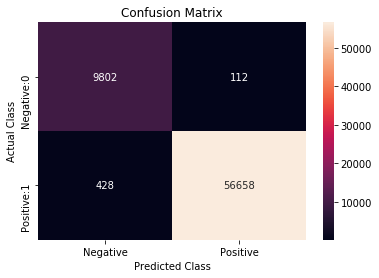

In [55]:
print("Heatmap of train confusion matrix")
import seaborn as sns
confusion_matrix_train_tfidf = confusion_matrix(y_train, rf_tfidf.predict(x_train_tf_idf))

df_cm=pd.DataFrame(confusion_matrix_train_tfidf,index=["Negative:0","Positive:1"],columns=["Negative","Positive"],)
sns.heatmap(df_cm,annot=True,fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")

Heatmap of train confusion matrix


Text(33,0.5,'Actual Class')

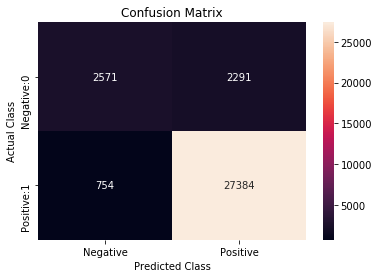

In [56]:
print("Heatmap of train confusion matrix")
import seaborn as sns
confusion_matrix_test_tfidf = confusion_matrix(y_test, rf_tfidf.predict(x_test_tf_idf))

df_cm=pd.DataFrame(confusion_matrix_test_tfidf,index=["Negative:0","Positive:1"],columns=["Negative","Positive"],)
sns.heatmap(df_cm,annot=True,fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")

### [5.2.1] Top 20 important features from<font color='red'> SET 2</font>

In [107]:
# Please write all the code with proper documentation


coefficients_1 = pd.DataFrame({"Feature":tf_idf_vect.get_feature_names(),"Coefficients":np.transpose(rf_tfidf.feature_importances_)})

coefficients_1=coefficients.sort_values('Coefficients',ascending=False)
coefficients_1 = coefficients.reset_index()
coefficients_1 = coefficients_1.drop(["index"],axis=1)
coefficients_1.head(20)

Feature  Coefficients
0            not      0.033977
1          great      0.032292
2           best      0.017446
3           love      0.014755
4      delicious      0.013046
5   disappointed      0.012114
6        perfect      0.008894
7          loves      0.008350
8           good      0.008176
9          money      0.007221
10      favorite      0.007020
11       not buy      0.006874
12         would      0.006687
13     wonderful      0.006478
14           bad      0.006150
15     excellent      0.005802
16          find      0.005675
17         worst      0.005519
18          easy      0.005490
19      terrible      0.005185

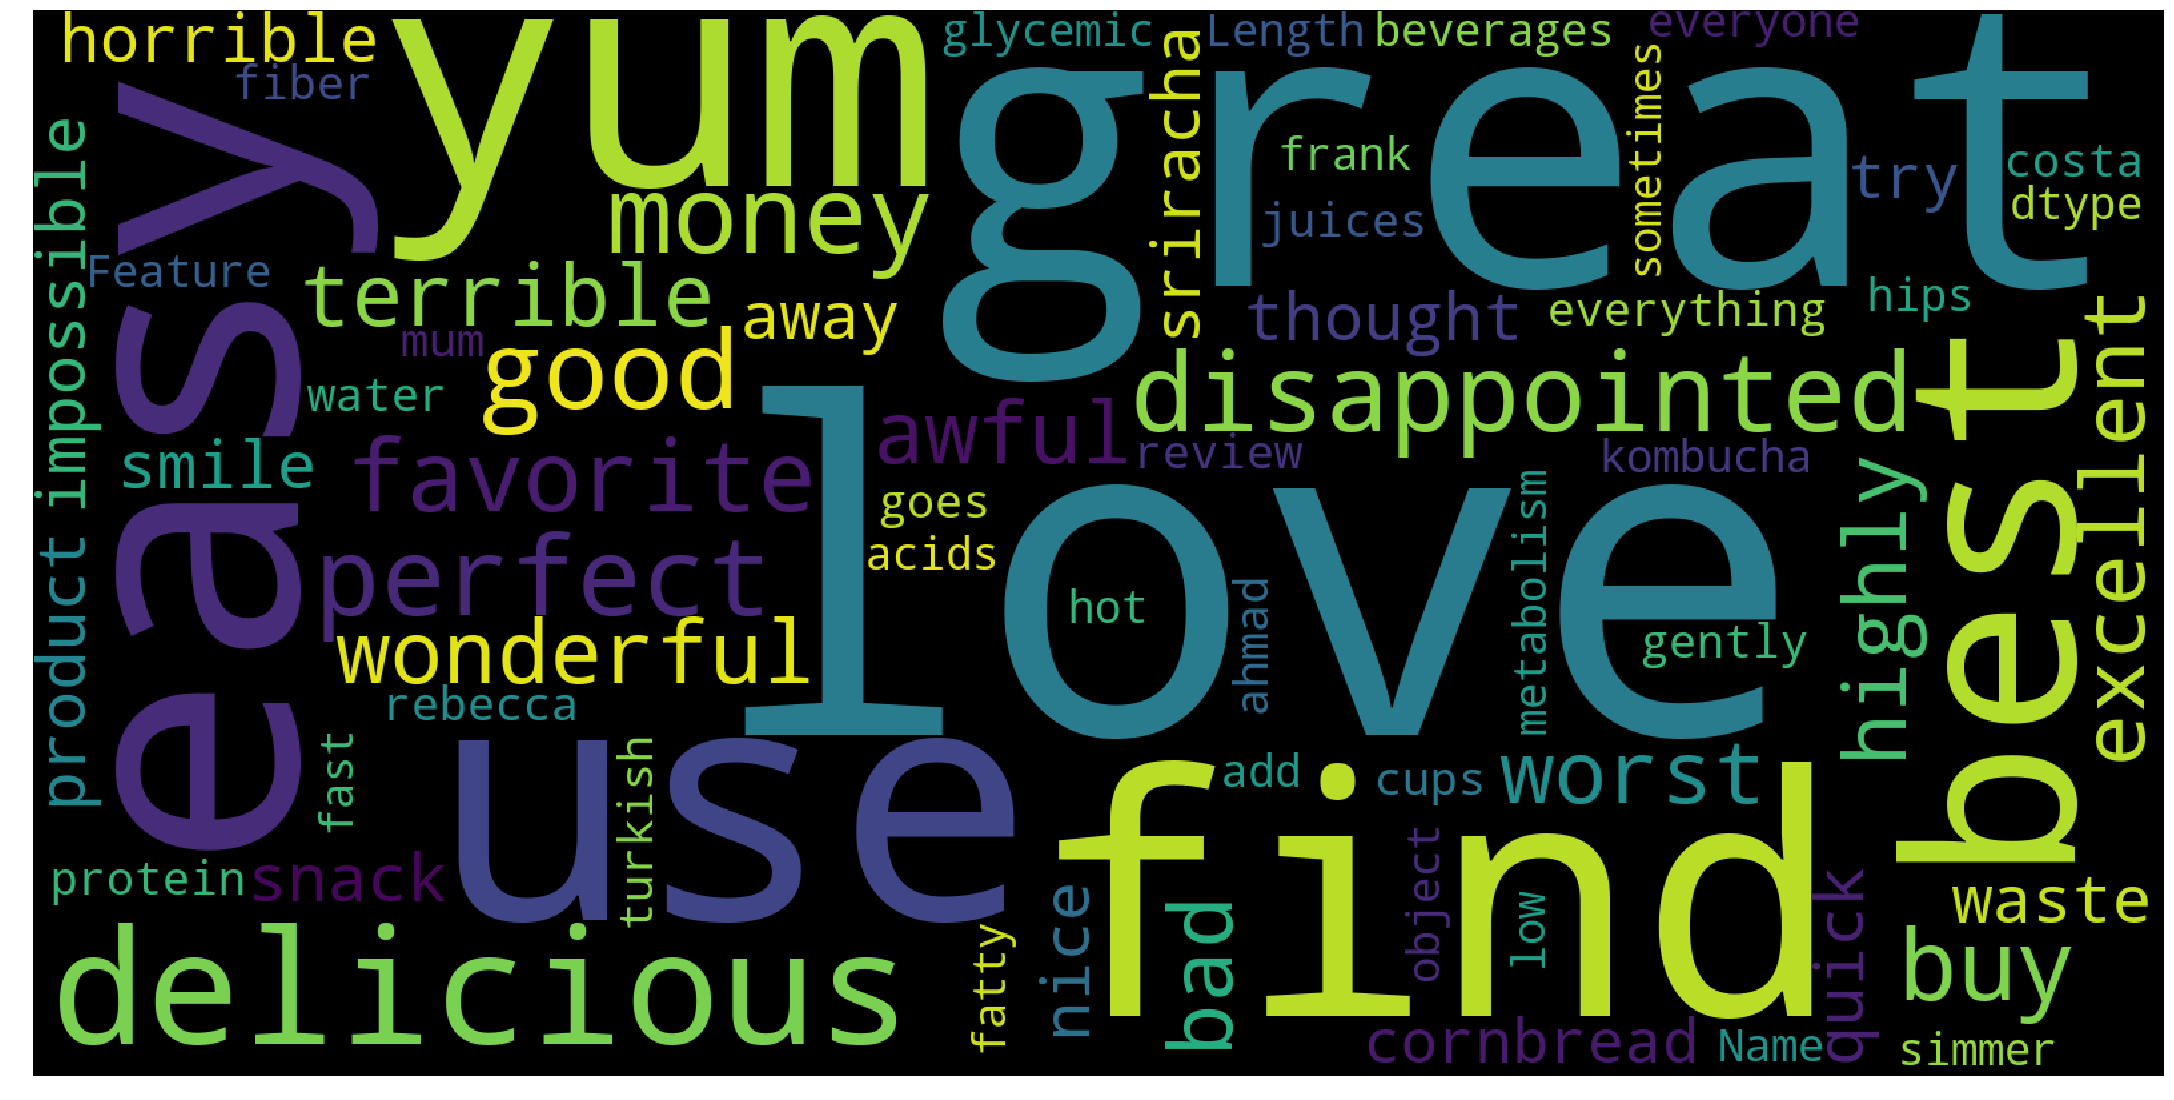

Time taken to run this cell : 0:00:02.584382


In [117]:
# Ploting word cloud
start = datetime.now()

# Lets first convert the 'result' dictionary to 'list of tuples'
#tup = dict(coefficients.items())
#Initializing WordCloud using frequencies of tags.
wordcloud = WordCloud(    background_color='black',
                          width=1600,
                          height=800,
                    ).generate(str(coefficients_1["Feature"]))

fig = plt.figure(figsize=(30,20))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
fig.savefig("tag.png")
plt.show()
print("Time taken to run this cell :", datetime.now() - start)

In [60]:
# Please write all the code with proper documentation

# Please write all the code with proper documentation

rf_model_avgw2v=RandomForestClassifier(class_weight='balanced')
parameters={'n_estimators':[5, 10, 50, 100, 500],
           'max_depth':[5 ,10 ,20 ,50 ,75]}
clf_avgw2v=GridSearchCV(rf_model_avgw2v,parameters,cv=10,scoring='roc_auc',n_jobs=-1)
clf_avgw2v.fit(sent_vectors_train, y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators='warn', n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [5, 10, 50, 100, 500], 'max_depth': [5, 10, 20, 50, 75]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

## Applying Random Forests on AVG W2V,<font color='red'> SET 3</font>

In [59]:
print("best estimator is :", clf_avgw2v.best_estimator_)

best estimator is : RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=100, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=100, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False)


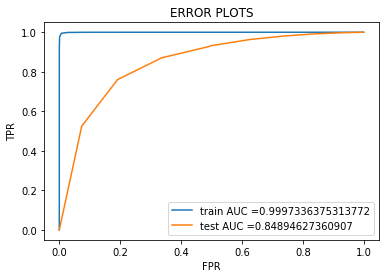

Train confusion matrix
[[ 9637   277]
 [   63 57023]]
Test confusion matrix
[[ 1811  3051]
 [ 1024 27114]]


In [61]:
# Please write all the code with proper documentation

rf_avgw2v = RandomForestClassifier(class_weight='balanced',n_estimators=10,max_depth=100)

rf_avgw2v.fit(sent_vectors_train, y_train)


train_fpr_avgw2v, train_tpr_avgw2v, thresholds_avgw2v = roc_curve(y_train, rf_avgw2v.predict_proba(sent_vectors_train)[:,1])
test_fpr_avgw2v, test_tpr_avgw2v, thresholds_avgw2v = roc_curve(y_test, rf_avgw2v.predict_proba(sent_vectors_test)[:,1])

plt.plot(train_fpr_avgw2v, train_tpr_avgw2v, label="train AUC ="+str(auc(train_fpr_avgw2v, train_tpr_avgw2v)))
plt.plot(test_fpr_avgw2v, test_tpr_avgw2v, label="test AUC ="+str(auc(test_fpr_avgw2v, test_tpr_avgw2v)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, rf_avgw2v.predict(sent_vectors_train)))
print("Test confusion matrix")
print(confusion_matrix(y_test, rf_avgw2v.predict(sent_vectors_test)))

In [142]:
#emptying train_auc and test_auc

train_auc[:] = []
test_auc[:] = []

calculate_auc_score(n_estimators, max_depth , sent_vectors_train ,sent_vectors_test)

In [143]:
trace1 = go.Scatter3d(x=n_estimators,y=max_depth,z=train_auc, name = 'train')
trace2 = go.Scatter3d(x=n_estimators,y=max_depth,z=test_auc, name = 'test')
data = [trace1, trace2]

layout = go.Layout(scene = dict(
        xaxis = dict(title='n_estimators'),
        yaxis = dict(title='max_depth'),
        zaxis = dict(title='AUC'),))

fig = go.Figure(data=data, layout=layout)
offline.iplot(fig, filename='3d-scatter-colorscale')

Heatmap of train confusion matrix


Text(33,0.5,'Actual Class')

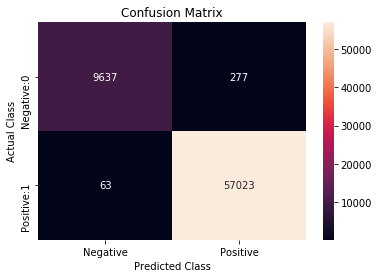

In [62]:
print("Heatmap of train confusion matrix")
import seaborn as sns
confusion_matrix_train_avgw2v = confusion_matrix(y_train, rf_avgw2v.predict(sent_vectors_train))

df_cm=pd.DataFrame(confusion_matrix_train_avgw2v,index=["Negative:0","Positive:1"],columns=["Negative","Positive"],)
sns.heatmap(df_cm,annot=True,fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")

Heatmap of test confusion matrix


Text(33,0.5,'Actual Class')

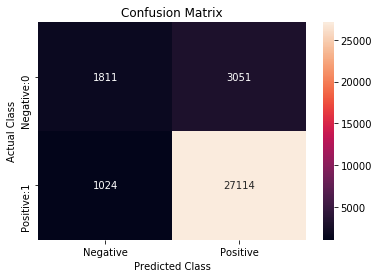

In [63]:
print("Heatmap of test confusion matrix")
import seaborn as sns
confusion_matrix_train_avgw2v = confusion_matrix(y_test, rf_avgw2v.predict(sent_vectors_test))

df_cm=pd.DataFrame(confusion_matrix_train_avgw2v,index=["Negative:0","Positive:1"],columns=["Negative","Positive"],)
sns.heatmap(df_cm,annot=True,fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")

## Applying Random Forests on TFIDF W2V,<font color='red'> SET 4</font>

In [64]:
# Please write all the code with proper documentation

rf_model_tfidfw2v=RandomForestClassifier(class_weight='balanced')
parameters={'n_estimators':[5, 10, 50, 100, 500],
           'max_depth':[5 ,10 ,20 ,50 ,75]}
clf_tfidfw2v=GridSearchCV(rf_model_tfidfw2v,parameters,cv=10,scoring='roc_auc',n_jobs=-1)
clf_tfidfw2v.fit(w2v_tfidf_sent_vectors_train, y_train)


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators='warn', n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [5, 10, 50, 100, 500], 'max_depth': [5, 10, 20, 50, 75]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [65]:
print("best estimator is :", clf_tfidfw2v.best_estimator_)

best estimator is : RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=50, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False)


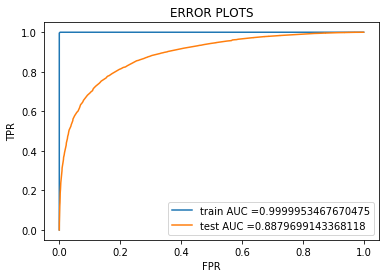

Train confusion matrix
[[ 9891    23]
 [    0 57086]]
Test confusion matrix
[[ 1137  3725]
 [  357 27781]]


In [67]:
# Please write all the code with proper documentation

rf_tfidfw2v = RandomForestClassifier(class_weight='balanced',n_estimators=500,max_depth=50)

rf_tfidfw2v.fit(w2v_tfidf_sent_vectors_train, y_train)


train_fpr_tfidfw2v, train_tpr_tfidfw2v, thresholds_tfidfw2v = roc_curve(y_train, rf_tfidfw2v.predict_proba(w2v_tfidf_sent_vectors_train)[:,1])
test_fpr_tfidfw2v, test_tpr_tfidfw2v, thresholds_tfidfw2v = roc_curve(y_test, rf_tfidfw2v.predict_proba(w2v_tfidf_sent_vectors_test)[:,1])

plt.plot(train_fpr_tfidfw2v, train_tpr_tfidfw2v, label="train AUC ="+str(auc(train_fpr_tfidfw2v, train_tpr_tfidfw2v)))
plt.plot(test_fpr_tfidfw2v, test_tpr_tfidfw2v, label="test AUC ="+str(auc(test_fpr_tfidfw2v, test_tpr_tfidfw2v)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, rf_tfidfw2v.predict(w2v_tfidf_sent_vectors_train)))
print("Test confusion matrix")
print(confusion_matrix(y_test, rf_tfidfw2v.predict(w2v_tfidf_sent_vectors_test)))

In [145]:
#emptying train_auc and test_auc
train_auc[:]=[]
test_auc[:]=[]

calculate_auc_score(n_estimators, max_depth , w2v_tfidf_sent_vectors_train ,w2v_tfidf_sent_vectors_test)

In [146]:

trace1 = go.Scatter3d(x=n_estimators,y=max_depth,z=train_auc, name = 'train')
trace2 = go.Scatter3d(x=n_estimators,y=max_depth,z=test_auc, name = 'test')
data = [trace1, trace2]

layout = go.Layout(scene = dict(
        xaxis = dict(title='n_estimators'),
        yaxis = dict(title='max_depth'),
        zaxis = dict(title='AUC'),))

fig = go.Figure(data=data, layout=layout)
offline.iplot(fig, filename='3d-scatter-colorscale')

Heatmap of train confusion matrix


Text(33,0.5,'Actual Class')

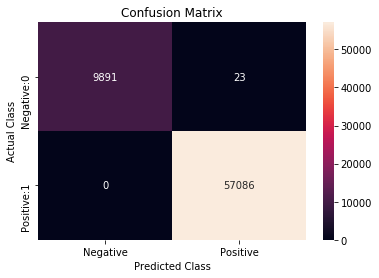

In [68]:
print("Heatmap of train confusion matrix")
import seaborn as sns
confusion_matrix_train_tfidfw2v = confusion_matrix(y_train, rf_tfidfw2v.predict(w2v_tfidf_sent_vectors_train))

df_cm=pd.DataFrame(confusion_matrix_train_tfidfw2v,index=["Negative:0","Positive:1"],columns=["Negative","Positive"],)
sns.heatmap(df_cm,annot=True,fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")

Heatmap of test confusion matrix


Text(33,0.5,'Actual Class')

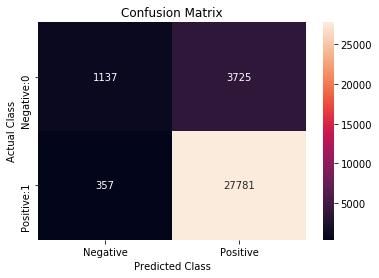

In [71]:
print("Heatmap of test confusion matrix")
import seaborn as sns
confusion_matrix_train_tfidfw2v = confusion_matrix(y_test, rf_tfidfw2v.predict(w2v_tfidf_sent_vectors_test))

df_cm=pd.DataFrame(confusion_matrix_train_tfidfw2v,index=["Negative:0","Positive:1"],columns=["Negative","Positive"],)
sns.heatmap(df_cm,annot=True,fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")

# Applying GBDT on BOW ,TFIDF ,AvgW2V ,TFIDF AvgW2V

## Applying GBDT on BOW 

In [45]:
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

parameters={'n_estimators':[5, 10, 50, 100, 500],
           'max_depth':[5 ,10 ,20 ,50 ,75]}

xgbcl_model_bow = XGBClassifier()
clf_xgb_bow=GridSearchCV(xgbcl_model_bow,parameters,cv=10,scoring='roc_auc',n_jobs=-1)
clf_xgb_bow.fit(x_train_bigram_counts, y_train) 

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [5, 10, 50, 100, 500], 'max_depth': [5, 10, 20, 50, 75]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [46]:
print("best estimator is :", clf_xgb_bow.best_estimator_)

best estimator is : XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=50, min_child_weight=1, missing=None, n_estimators=500,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)


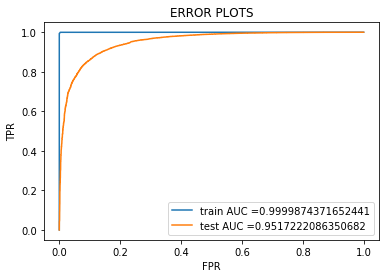

Train confusion matrix
[[ 9810    67]
 [    4 57119]]
Test confusion matrix
[[ 3013  1886]
 [  550 27551]]


In [47]:
# Please write all the code with proper documentation

xgb_bow = XGBClassifier(n_estimators=500,max_depth=50,scoring = 'roc_auc')

xgb_bow.fit(x_train_bigram_counts, y_train)


train_fpr_xgb_bow, train_tpr_xgb_bow, thresholds_xgb_bow = roc_curve(y_train, xgb_bow.predict_proba(x_train_bigram_counts)[:,1])
test_fpr_xgb_bow, test_tpr_xgb_bow, thresholds_xgb_bow = roc_curve(y_test, xgb_bow.predict_proba(x_test_bigram_counts)[:,1])

plt.plot(train_fpr_xgb_bow, train_tpr_xgb_bow, label="train AUC ="+str(auc(train_fpr_xgb_bow, train_tpr_xgb_bow)))
plt.plot(test_fpr_xgb_bow, test_tpr_xgb_bow, label="test AUC ="+str(auc(test_fpr_xgb_bow, test_tpr_xgb_bow)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, xgb_bow.predict(x_train_bigram_counts)))
print("Test confusion matrix")
print(confusion_matrix(y_test, xgb_bow.predict(x_test_bigram_counts)))

In [48]:
n_estimators=[5, 10, 50, 100, 500]
max_depth = [5 ,10 ,20 ,50 ,75]
train_auc = []
test_auc = []
def calculate_auc_score(n_estimators , max_depth, train_data ,test_data):
    for i , j  in zip(n_estimators, max_depth):
        xgb_model = XGBClassifier(n_estimators = i,max_depth = j , class_weight="balanced")
        xgb_model.fit(train_data, y_train)
        train_fpr, train_tpr, thresholds = roc_curve(y_train, xgb_model.predict_proba(train_data)[:,1])
        test_fpr, test_tpr, thresholds = roc_curve(y_test, xgb_model.predict_proba(test_data)[:,1])
        train_auc.append(auc(train_fpr, train_tpr))
        test_auc.append(auc(test_fpr, test_tpr))

In [49]:
#emptying train_auc and test_auc
train_auc[:]=[]
test_auc[:]=[]

calculate_auc_score(n_estimators, max_depth , x_train_bigram_counts ,x_test_bigram_counts)

In [50]:
trace1 = go.Scatter3d(x=n_estimators,y=max_depth,z=train_auc, name = 'train')
trace2 = go.Scatter3d(x=n_estimators,y=max_depth,z=test_auc, name = 'test')
data = [trace1, trace2]

layout = go.Layout(scene = dict(
        xaxis = dict(title='n_estimators'),
        yaxis = dict(title='max_depth'),
        zaxis = dict(title='AUC'),))

fig = go.Figure(data=data, layout=layout)
offline.iplot(fig, filename='3d-scatter-colorscale')

Heatmap of train confusion matrix


Text(33,0.5,'Actual Class')

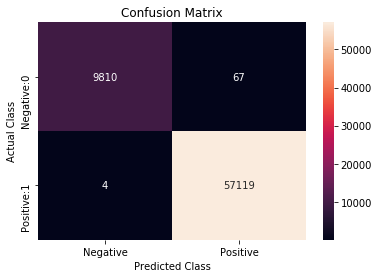

In [51]:
print("Heatmap of train confusion matrix")
import seaborn as sns
confusion_matrix_train_xgb_bow = confusion_matrix(y_train, xgb_bow.predict(x_train_bigram_counts))

df_cm=pd.DataFrame(confusion_matrix_train_xgb_bow,index=["Negative:0","Positive:1"],columns=["Negative","Positive"],)
sns.heatmap(df_cm,annot=True,fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")

Heatmap of test confusion matrix


Text(33,0.5,'Actual Class')

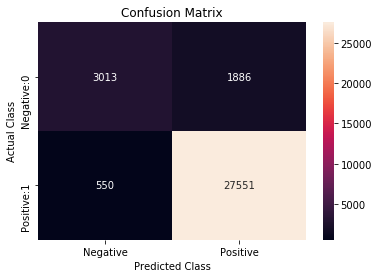

In [52]:
print("Heatmap of test confusion matrix")
import seaborn as sns
confusion_matrix_test_xgb_bow = confusion_matrix(y_test, xgb_bow.predict(x_test_bigram_counts))

df_cm=pd.DataFrame(confusion_matrix_test_xgb_bow,index=["Negative:0","Positive:1"],columns=["Negative","Positive"],)
sns.heatmap(df_cm,annot=True,fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")

# Applying GBDT on TFIDF

In [53]:
from xgboost import XGBClassifier


parameters={'n_estimators':[5, 10, 50, 100, 500],
           'max_depth':[5 ,10 ,20 ,50 ,75]}

xgbcl_model_tfidf = XGBClassifier()
clf_xgb_tfidf=GridSearchCV(xgbcl_model_tfidf,parameters,cv=10,scoring='roc_auc',n_jobs=-1)
clf_xgb_tfidf.fit(x_train_tf_idf, y_train) 

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [5, 10, 50, 100, 500], 'max_depth': [5, 10, 20, 50, 75]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [55]:
print("best estimator is :", clf_xgb_tfidf.best_estimator_)

best estimator is : XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=20, min_child_weight=1, missing=None, n_estimators=500,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)


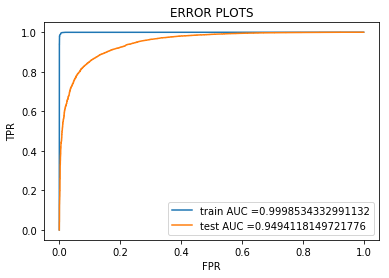

Train confusion matrix
[[ 9619   258]
 [   13 57110]]
Test confusion matrix
[[ 2890  2009]
 [  513 27588]]


In [64]:
# Please write all the code with proper documentation

xgb_tfidf = XGBClassifier(n_estimators=500,max_depth=20,scoring = 'roc_auc')

xgb_tfidf.fit(x_train_tf_idf, y_train)


train_fpr_xgb_tfidf, train_tpr_xgb_tfidf, thresholds_xgb_tfidf = roc_curve(y_train, xgb_tfidf.predict_proba(x_train_tf_idf)[:,1])
test_fpr_xgb_tfidf, test_tpr_xgb_tfidf, thresholds_xgb_tfidf = roc_curve(y_test, xgb_tfidf.predict_proba(x_test_tf_idf)[:,1])

plt.plot(train_fpr_xgb_tfidf, train_tpr_xgb_tfidf, label="train AUC ="+str(auc(train_fpr_xgb_tfidf, train_tpr_xgb_tfidf)))
plt.plot(test_fpr_xgb_tfidf, test_tpr_xgb_tfidf, label="test AUC ="+str(auc(test_fpr_xgb_tfidf, test_tpr_xgb_tfidf)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, xgb_tfidf.predict(x_train_tf_idf)))
print("Test confusion matrix")
print(confusion_matrix(y_test, xgb_tfidf.predict(x_test_tf_idf)))

In [58]:
#emptying train_auc and test_auc
train_auc[:]=[]
test_auc[:]=[]

calculate_auc_score(n_estimators, max_depth , x_train_tf_idf ,x_test_tf_idf)

In [59]:
trace1 = go.Scatter3d(x=n_estimators,y=max_depth,z=train_auc, name = 'train')
trace2 = go.Scatter3d(x=n_estimators,y=max_depth,z=test_auc, name = 'test')
data = [trace1, trace2]

layout = go.Layout(scene = dict(
        xaxis = dict(title='n_estimators'),
        yaxis = dict(title='max_depth'),
        zaxis = dict(title='AUC'),))

fig = go.Figure(data=data, layout=layout)
offline.iplot(fig, filename='3d-scatter-colorscale')

Heatmap of train confusion matrix


Text(33,0.5,'Actual Class')

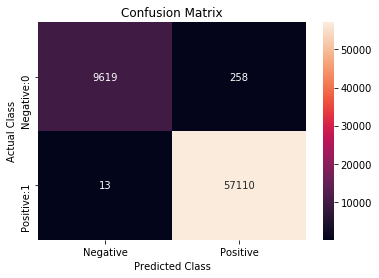

In [60]:
print("Heatmap of train confusion matrix")
import seaborn as sns
confusion_matrix_train_xgb_tfidf = confusion_matrix(y_train, xgb_tfidf.predict(x_train_tf_idf))

df_cm=pd.DataFrame(confusion_matrix_train_xgb_tfidf,index=["Negative:0","Positive:1"],columns=["Negative","Positive"],)
sns.heatmap(df_cm,annot=True,fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")

Heatmap of test confusion matrix


Text(33,0.5,'Actual Class')

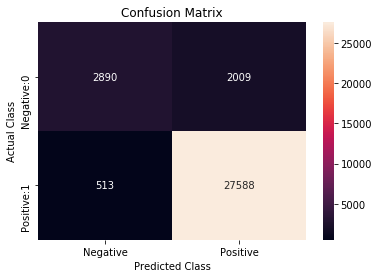

In [61]:
print("Heatmap of test confusion matrix")

confusion_matrix_test_xgb_tfidf = confusion_matrix(y_test, xgb_tfidf.predict(x_test_tf_idf))

df_cm=pd.DataFrame(confusion_matrix_test_xgb_tfidf,index=["Negative:0","Positive:1"],columns=["Negative","Positive"],)
sns.heatmap(df_cm,annot=True,fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")

# Applying GBDT on Avg W2V

In [62]:
#Avg W2V
xgbcl_model_avgw2v = XGBClassifier()
clf_xgb_avgw2v=GridSearchCV(xgbcl_model_avgw2v,parameters,cv=10,scoring='roc_auc',n_jobs=-1)
clf_xgb_avgw2v.fit(sent_vectors_train, y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [5, 10, 50, 100, 500], 'max_depth': [5, 10, 20, 50, 75]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [63]:
print("best estimator is :", clf_xgb_avgw2v.best_estimator_)

best estimator is : XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=50, min_child_weight=1, missing=None, n_estimators=500,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)


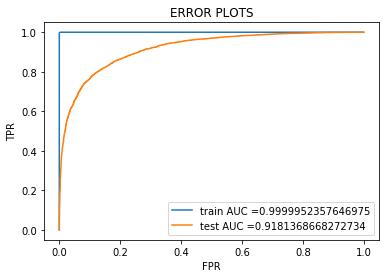

Train confusion matrix
[[ 9851    26]
 [    0 57123]]
Test confusion matrix
[[ 2323  2576]
 [  741 27360]]


In [65]:
# Please write all the code with proper documentation

xgb_avgw2v = XGBClassifier(n_estimators=500,max_depth=50,scoring = 'roc_auc')

xgb_avgw2v.fit(sent_vectors_train, y_train)


train_fpr_xgb_avgw2v, train_tpr_xgb_avgw2v, thresholds_xgb_avgw2v = roc_curve(y_train, xgb_avgw2v.predict_proba(sent_vectors_train)[:,1])
test_fpr_xgb_avgw2v, test_tpr_xgb_avgw2v, thresholds_xgb_avgw2v = roc_curve(y_test, xgb_avgw2v.predict_proba(sent_vectors_test)[:,1])

plt.plot(train_fpr_xgb_avgw2v, train_tpr_xgb_avgw2v, label="train AUC ="+str(auc(train_fpr_xgb_avgw2v, train_tpr_xgb_avgw2v)))
plt.plot(test_fpr_xgb_avgw2v, test_tpr_xgb_avgw2v, label="test AUC ="+str(auc(test_fpr_xgb_avgw2v, test_tpr_xgb_avgw2v)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, xgb_avgw2v.predict(sent_vectors_train)))
print("Test confusion matrix")
print(confusion_matrix(y_test, xgb_avgw2v.predict(sent_vectors_test)))

In [66]:
#emptying train_auc and test_auc
train_auc[:]=[]
test_auc[:]=[]

calculate_auc_score(n_estimators, max_depth , sent_vectors_train ,sent_vectors_test)

In [67]:
trace1 = go.Scatter3d(x=n_estimators,y=max_depth,z=train_auc, name = 'train')
trace2 = go.Scatter3d(x=n_estimators,y=max_depth,z=test_auc, name = 'test')
data = [trace1, trace2]

layout = go.Layout(scene = dict(
        xaxis = dict(title='n_estimators'),
        yaxis = dict(title='max_depth'),
        zaxis = dict(title='AUC'),))

fig = go.Figure(data=data, layout=layout)
offline.iplot(fig, filename='3d-scatter-colorscale')

Heatmap of train confusion matrix


Text(33,0.5,'Actual Class')

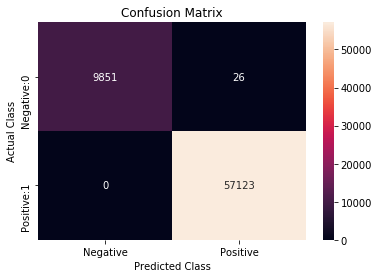

In [68]:
print("Heatmap of train confusion matrix")
import seaborn as sns
confusion_matrix_train_xgb_avgw2v = confusion_matrix(y_train, xgb_avgw2v.predict(sent_vectors_train))

df_cm=pd.DataFrame(confusion_matrix_train_xgb_avgw2v,index=["Negative:0","Positive:1"],columns=["Negative","Positive"],)
sns.heatmap(df_cm,annot=True,fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")

Heatmap of test confusion matrix


Text(33,0.5,'Actual Class')

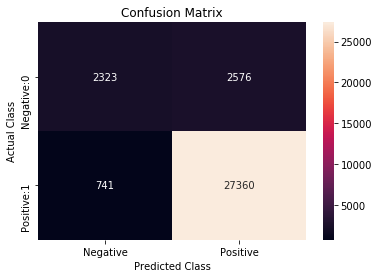

In [69]:
print("Heatmap of test confusion matrix")
import seaborn as sns
confusion_matrix_test_xgb_avgw2v = confusion_matrix(y_test, xgb_avgw2v.predict(sent_vectors_test))

df_cm=pd.DataFrame(confusion_matrix_test_xgb_avgw2v,index=["Negative:0","Positive:1"],columns=["Negative","Positive"],)
sns.heatmap(df_cm,annot=True,fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")

# Applying GBDT on TFIDF Wegihted W2V

In [118]:
#TFIDF weighted w2v
xgbcl_model_tfidfavgw2v = XGBClassifier()
clf_xgb_tfidfavgw2v=GridSearchCV(xgbcl_model_tfidfavgw2v,parameters,cv=10,scoring='roc_auc',n_jobs=-1)
w2v_tfidf_sent_vectors_train = np.asarray(w2v_tfidf_sent_vectors_train)
clf_xgb_tfidfavgw2v.fit(w2v_tfidf_sent_vectors_train, y_train)




GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [5, 10, 50, 100, 500], 'max_depth': [5, 10, 20, 50, 75]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [119]:
print("best estimator is :", clf_xgb_tfidfavgw2v.best_estimator_)

best estimator is : XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=50, min_child_weight=1, missing=None, n_estimators=500,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)


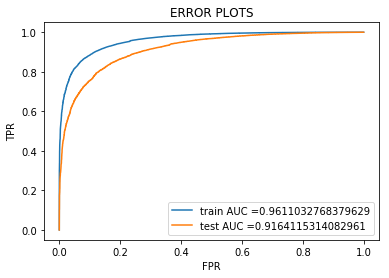

Train confusion matrix
[[ 9969    26]
 [    0 57005]]
Test confusion matrix
[[ 1982  2799]
 [  664 27555]]


In [120]:
# Please write all the code with proper documentation

xgb_tfidfavgw2v = XGBClassifier(n_estimators=500,max_depth=50,scoring = 'roc_auc')

xgb_tfidfavgw2v.fit(w2v_tfidf_sent_vectors_train, y_train)


train_fpr_xgb_tfidfavgw2v, train_tpr_xgb_tfidfavgw2v, thresholds_xgb_tfidfavgw2v = roc_curve(y_train, xgb_tfidfavgw2v.predict_proba(sent_vectors_train)[:,1])
test_fpr_xgb_tfidfavgw2v, test_tpr_xgb_tfidfavgw2v, thresholds_xgb_tfidfavgw2v = roc_curve(y_test, xgb_tfidfavgw2v.predict_proba(sent_vectors_test)[:,1])

plt.plot(train_fpr_xgb_tfidfavgw2v, train_tpr_xgb_tfidfavgw2v, label="train AUC ="+str(auc(train_fpr_xgb_tfidfavgw2v, train_tpr_xgb_tfidfavgw2v)))
plt.plot(test_fpr_xgb_tfidfavgw2v, test_tpr_xgb_tfidfavgw2v, label="test AUC ="+str(auc(test_fpr_xgb_tfidfavgw2v, test_tpr_xgb_tfidfavgw2v)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, xgb_tfidfavgw2v.predict(w2v_tfidf_sent_vectors_train)))
print("Test confusion matrix")
print(confusion_matrix(y_test, xgb_tfidfavgw2v.predict(w2v_tfidf_sent_vectors_test)))

In [121]:
#emptying train_auc and test_auc
train_auc[:]=[]
test_auc[:]=[]

calculate_auc_score(n_estimators, max_depth , w2v_tfidf_sent_vectors_train ,w2v_tfidf_sent_vectors_test)

In [122]:
trace1 = go.Scatter3d(x=n_estimators,y=max_depth,z=train_auc, name = 'train')
trace2 = go.Scatter3d(x=n_estimators,y=max_depth,z=test_auc, name = 'test')
data = [trace1, trace2]

layout = go.Layout(scene = dict(
        xaxis = dict(title='n_estimators'),
        yaxis = dict(title='max_depth'),
        zaxis = dict(title='AUC'),))

fig = go.Figure(data=data, layout=layout)
offline.iplot(fig, filename='3d-scatter-colorscale')

Heatmap of train confusion matrix


Text(33,0.5,'Actual Class')

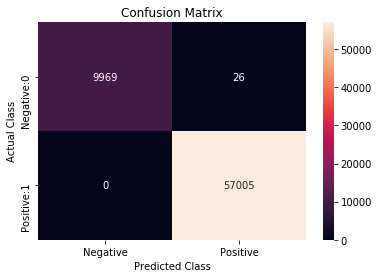

In [123]:
print("Heatmap of train confusion matrix")
import seaborn as sns
confusion_matrix_train_xgb_tfidfavgw2v = confusion_matrix(y_train, xgb_tfidfavgw2v.predict(w2v_tfidf_sent_vectors_train))

df_cm=pd.DataFrame(confusion_matrix_train_xgb_tfidfavgw2v,index=["Negative:0","Positive:1"],columns=["Negative","Positive"],)
sns.heatmap(df_cm,annot=True,fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")

Heatmap of test confusion matrix


Text(33,0.5,'Actual Class')

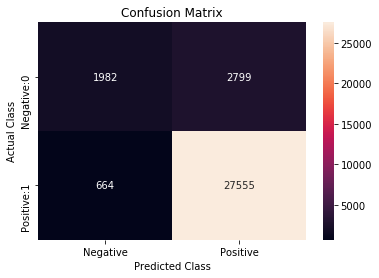

In [124]:
print("Heatmap of test confusion matrix")
import seaborn as sns
confusion_matrix_test_xgb_tfidfavgw2v = confusion_matrix(y_test, xgb_tfidfavgw2v.predict(w2v_tfidf_sent_vectors_test))

df_cm=pd.DataFrame(confusion_matrix_test_xgb_tfidfavgw2v,index=["Negative:0","Positive:1"],columns=["Negative","Positive"],)
sns.heatmap(df_cm,annot=True,fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")

In [129]:
from prettytable import PrettyTable

X = PrettyTable()
print("Comparison Table : Random Forest Applied on BOW ,TFIDF ,AvgW2V ,TFIDFWeightedW2V")
X.field_names=["Model_Name","Train_Accuracy","Test_Accuracy","Best n_estimators" ,"Best max_depth"]
X.add_row(["Random Forest With BOW", 99.9, 93.3,500, 100])
X.add_row(["Random Forest With TFIDF",99.9, 93.1,500,75])
X.add_row(["Random Forest With AVG W2V", 99.9, 84.8,10,100])
X.add_row(["Random Forest With TFIDF-AvgW2V", 99.9,88.7,500,50])

print(X)
print("\n")
print("="*100)
print("\n")
print("Comparison Table : GBDT applied on BOW ,TFIDF ,AvgW2V ,TFIDFWeightedW2V")
Y = PrettyTable()
Y.field_names = ["Model_Name" ,"Train_Accuracy" ,"Test_Accuracy" ,"Best n_estimators" ,"Best max_depth"]
Y.add_row(["GBDT With BOW", 99.9, 95.1,500, 50])
Y.add_row(["GBDT With TFIDF", 99.9, 94.9,500, 20])
Y.add_row(["GBDT With AvgW2V", 99.9, 91.8,500, 50])
Y.add_row(["GBDT With TFIDFWeightedW2V", 96.1, 91.6,500, 50])

print(Y)


Comparison Table : Random Forest Applied on BOW ,TFIDF ,AvgW2V ,TFIDFWeightedW2V
+---------------------------------+----------------+---------------+-------------------+----------------+
|            Model_Name           | Train_Accuracy | Test_Accuracy | Best n_estimators | Best max_depth |
+---------------------------------+----------------+---------------+-------------------+----------------+
|      Random Forest With BOW     |      99.9      |      93.3     |        500        |      100       |
|     Random Forest With TFIDF    |      99.9      |      93.1     |        500        |       75       |
|    Random Forest With AVG W2V   |      99.9      |      84.8     |         10        |      100       |
| Random Forest With TFIDF-AvgW2V |      99.9      |      88.7     |        500        |       50       |
+---------------------------------+----------------+---------------+-------------------+----------------+




Comparison Table : GBDT applied on BOW ,TFIDF ,AvgW2V ,TFIDFWeighte